In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

import salishsea_tools

import datetime
import os

import nowcast
import nowcast.figures.shared

from matplotlib import gridspec

from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools, geo_tools)

%matplotlib inline

import scipy.io as sio

In [2]:
def tracer_thalweg_and_surface(grid_T, var_name, bathy, lons, lats, mesh_mask):
    
    coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
    
    var = grid_T.variables[var_name][0,:,:,:]
    
    lon_range = (-124.2,-122.6)
    lat_range = (48,49.6)
    
    
    vmin = 6
    vmax = 34
    clevels = np.arange(vmin,vmax,1)
    
    fig = plt.figure(figsize=(16, 8)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.68, 1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    cmap = plt.get_cmap('jet')
    
    
    
    cbar = vis.contour_thalweg(ax1, var, bathy, lons, lats, mesh_mask, 'gdept', clevels = clevels, cmap=cmap)
    ax1.set_ylim([450,0])
    cbar.remove()
        
    viz_tools.set_aspect(ax1)
    
    si, ei = 165, 590
    sj, ej = 55, 365
    lons = lons[si:ei, sj:ej]
    lats = lats[si:ei, sj:ej]
    var = var[0,si:ei, sj:ej]
    var_ma = np.ma.masked_values(var[:, :], 0)
    
    nowcast.figures.shared.plot_map(ax2,coastline, lon_range = lon_range, lat_range = lat_range)
    mesh = ax2.contourf(lons, lats, var_ma, levels = clevels, cmap=cmap,extend='both', vmin=vmin, vmax=vmax)
    
    
    #mesh = ax2.pcolormesh(var[0,:,:], cmap='jet')#, vmin=vmin, vmax=vmax)
    fig.colorbar(mesh, ax=ax2,fraction=0.046, pad=0.04)
    #ax2.set_title('Surface {label}'.format(label=conc.long_name.title()), fontsize=16)
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.tight_layout()
    
    return(fig)

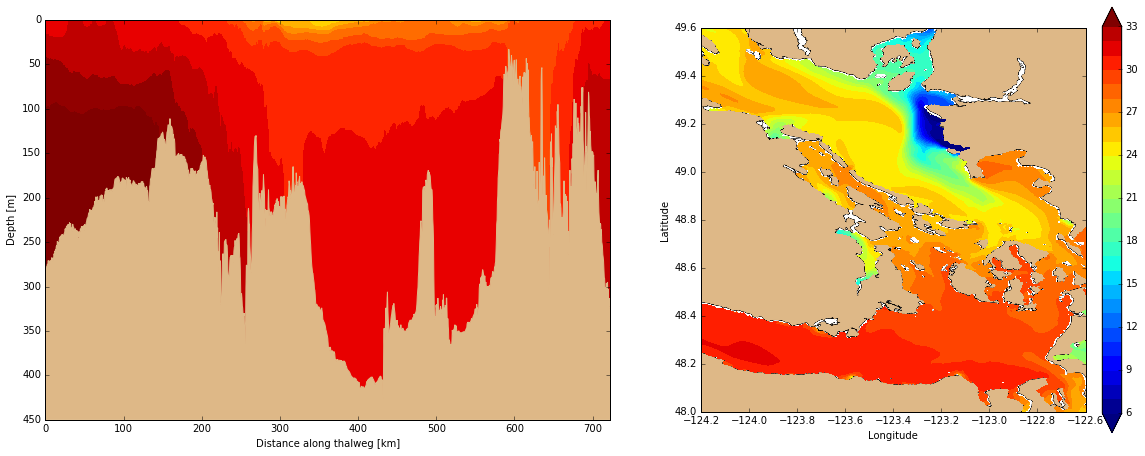

In [3]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')


grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, lons, lats = tidetools.get_bathy_data(grid_B)

grid_T = nc.Dataset('/results/SalishSea/nowcast/01apr16/SalishSea_1d_20160401_20160401_grid_T.nc')

thalweg_and_surface_plot = tracer_thalweg_and_surface(grid_T, 'vosaline', bathy, lons, lats, mesh_mask)

plt.show(thalweg_and_surface_plot)